In [8]:
import os
from os.path import join, isdir, isfile

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tifffile as tiff 
from tqdm.auto import tqdm

plt.style.use("Solarize_Light2")

# Wandb Login
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: ERROR API key must be 40 characters long, yours was 48
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/thanhnv/.netrc


True

In [10]:
class config:
    BASE_PATH = "../../hubmap-organ-segmentation/"
    TRAIN_PATH = os.path.join(BASE_PATH, "train")

# wandb config
WANDB_CONFIG = {
     'competition': 'HuBMAP', 
              '_wandb_kernel': 'neuracort'
    }

# Initialize W&B
run = wandb.init(
    project='hubmap-organ-segmentation', 
    config= WANDB_CONFIG
)

wandb: Currently logged in as: nguyen-van-thanh-hust. Use `wandb login --relogin` to force relogin


In [11]:
df = pd.read_csv(
    os.path.join(config.BASE_PATH, "train.csv")
)
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [12]:
%%capture
wandb.log({"df_train": df})

In [13]:
labels = img_id_1 = 10044
img_1 = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_1) + ".tiff")
print(img_1.shape)

(3000, 3000, 3)


(-0.5, 2999.5, 2999.5, -0.5)

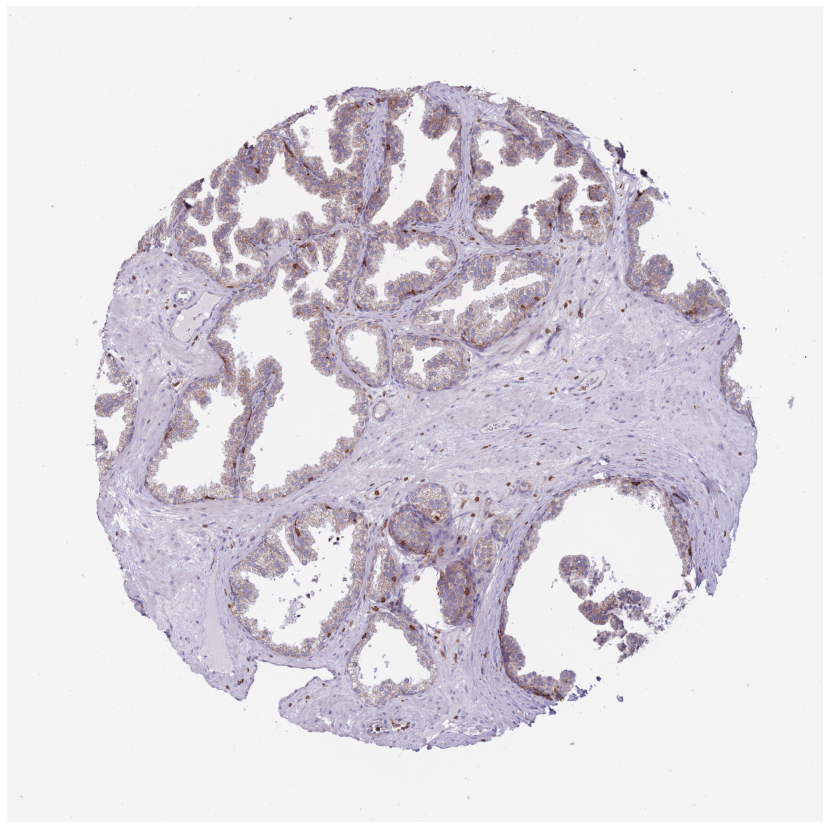

In [14]:
plt.figure(figsize=(15, 15))
plt.imshow(img_1)
plt.axis("off")

In [15]:
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [16]:
mask_1 = rle2mask(df[df["id"]==img_id_1]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
mask_1.shape

(3000, 3000)

(-0.5, 2999.5, 2999.5, -0.5)

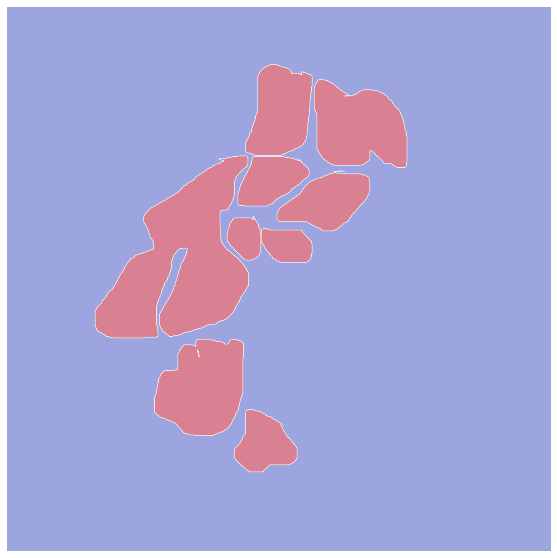

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")

(-0.5, 2999.5, 2999.5, -0.5)

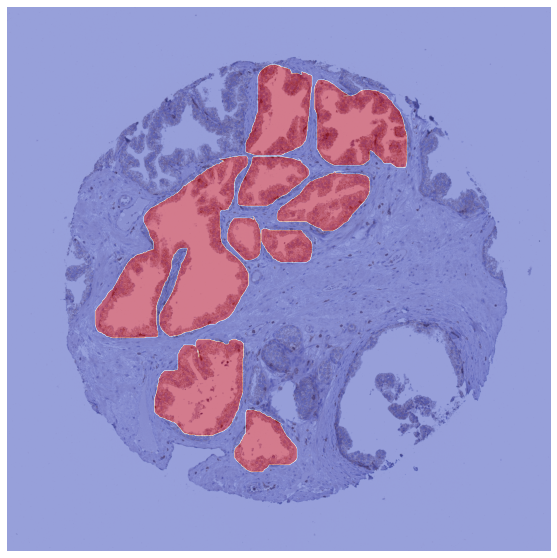

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")